### Overview
The primary objective of this project is to analyze the factors contributing to the reported decline in sales for SalesEase, an online retailer, and provide insights to reverse this trend. 


**The Issue: Declining Sales**
- Six months of continuous decline in sales reported by the SalesEase management.
- Concerns about the sustainability of the business.
- Need to understand underlying factors affecting sales performance.


**Solution: Conduct Exploratory Data Analysis (EDA) to uncover insights**

The key areas of focus include identifying product categories' performance, understanding customer behavior, evaluating sales channels' effectiveness, and optimizing various aspects of the e-commerce operation.

### Project Steps
1. Data Exploration
2. Time Series Analysis
3. Customer Segmentation Analysis
4. Product Analysis
5. Payment and Returns Analysis
6. Insights and Recommendations

## 1. Loading, inspecting and validating the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/ShopEase.csv')
df.shape

(1000, 12)

In [3]:
df.head()

,OrderID,ProductID,Category,ProductName,Quantity,Price,TotalAmount,OrderDate,CustomerID,PaymentMethod,SalesChannel,IsReturned
0,1,272,Electronics,Product_272,3,54.21,162.63,2022-04-21 01:48:37,26,Credit Card,In-Store,1
1,2,147,Electronics,Product_147,3,163.68,491.04,2022-02-26 03:09:32,38,Cash,Website,1
2,3,217,Fashion,Product_217,5,205.01,1025.05,2022-07-24 07:00:57,271,Cash,Website,0
3,4,292,Electronics,Product_292,4,163.13,652.52,2022-01-09 09:49:05,414,Cash,Website,1
4,5,423,Fashion,Product_423,3,608.73,1826.19,2022-05-19 09:38:52,368,Cash,Mobile App,1


In [4]:
duplicate_rows = df.duplicated()
duplicate_rows.sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OrderID        1000 non-null   int64  
 1   ProductID      1000 non-null   int64  
 2   Category       1000 non-null   object 
 3   ProductName    1000 non-null   object 
 4   Quantity       1000 non-null   int64  
 5   Price          1000 non-null   float64
 6   TotalAmount    1000 non-null   float64
 7   OrderDate      1000 non-null   object 
 8   CustomerID     1000 non-null   int64  
 9   PaymentMethod  1000 non-null   object 
 10  SalesChannel   1000 non-null   object 
 11  IsReturned     1000 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB


**Observations and insights**

'OrderDate' column needs to be converted to datetime format for plotting and time-based analysis.

## 2. Time Series Analysis

In [6]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [7]:
# Data prep. for plotting: Extract the month and year from 'OrderDate'
df['YearMonth'] = df['OrderDate'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('YearMonth')['TotalAmount'].sum().reset_index()

In [8]:
df['Month'] = df['OrderDate'].dt.strftime('%b')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
month_sales = df.groupby('Month', observed=False)['TotalAmount'].sum().reset_index()

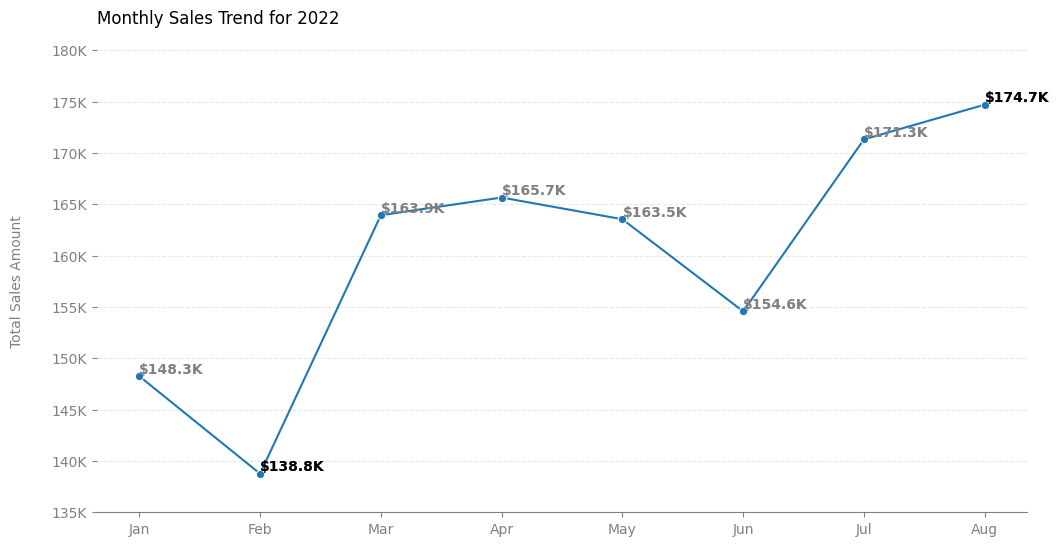

In [9]:
plt.figure(figsize=(12, 6))
g = sns.lineplot(x='Month', y='TotalAmount', data=month_sales, marker='o')
plt.title('Monthly Sales Trend for 2022', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Sales Amount', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

sns.despine()
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

for index, row in month_sales.iterrows():
     plt.text(row['Month'], row['TotalAmount'], f"${round(row['TotalAmount']/1000, 1)}K", ha='left', va='bottom', color='grey', fontweight='bold')
# Change text colour for max and min sales amount
max_s = month_sales.loc[month_sales['TotalAmount'].idxmax()]
min_s = month_sales.loc[month_sales['TotalAmount'].idxmin()]
plt.text(max_s['Month'], max_s['TotalAmount'], f"${round(max_s['TotalAmount']/1000, 1)}K", ha='left', va='bottom', fontsize=10, fontweight='bold')
plt.text(min_s['Month'], min_s['TotalAmount'], f"${round(min_s['TotalAmount']/1000, 1)}K", ha='left', va='bottom', fontsize=10, fontweight='bold')
plt.show()

**Observations and insights**

Although a comprehensive understanding of seasonal trends would require additional data, the trend observed here suggests that the business experiences fluctuations in demand throughout the year. 

Months like April, July, and August shows higher total sales amounts compared to other months, with February sales being the lowest.
[Holiday seasons, promotions](https://usapostline.com/en/articles/sales-calendar-in-usa-best-shopping-days), [product releases or special events](https://opas.com/blog/the-ultimate-us-sales-dates-cheat-sheet/) might play a role here and need to be explored further. 

In July most online stores offer Summer Clearance on casual clothes and shoes, electronics, home appliances, 40-50%. School supplies goes on offer with 25-65% off in August.

It would be helpful to see data for multiple years to account for year-to-year variations.

In [10]:
df['Weekday'] = df['OrderDate'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)
weekday_sales = df.groupby('Weekday', observed=False)['TotalAmount'].sum().reset_index()

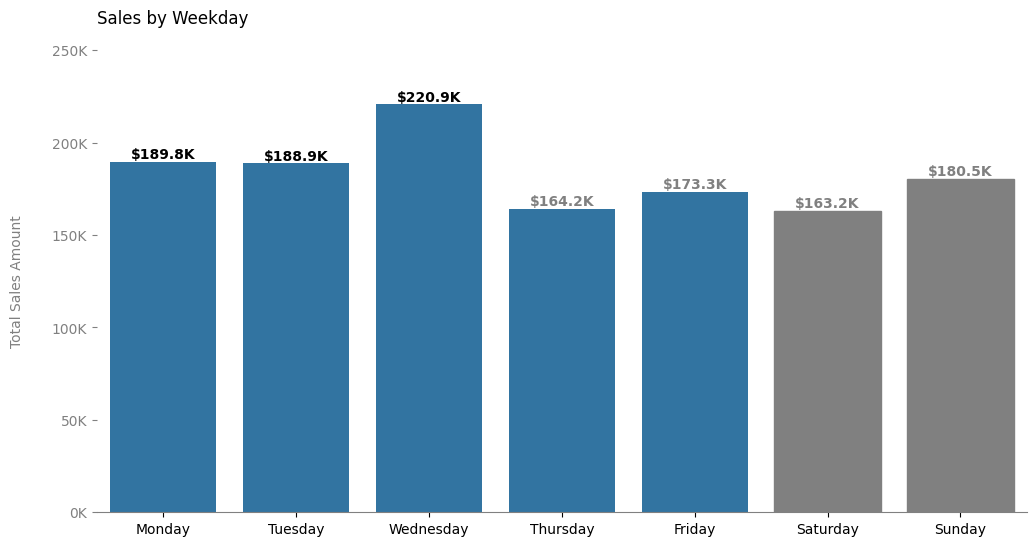

In [11]:
plt.figure(figsize=(12, 6))
g = sns.barplot(x='Weekday', y='TotalAmount', data=weekday_sales)
# Set gray for weekends
for index, bar in enumerate(g.patches):
    if weekday_sales.loc[index, 'Weekday'] in ['Saturday', 'Sunday']:
        bar.set_color('grey')

plt.title('Sales by Weekday', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Sales Amount', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

# Change text colour for top 3 weekdays
weekday_sales_sorted = weekday_sales.sort_values(by='TotalAmount', ascending=False)
for index, row in weekday_sales.iterrows():
    text_color = 'black' if index < 3 else 'grey'
    plt.text(index, row['TotalAmount'], f"${round(row['TotalAmount']/1000, 1)}K",
                                        ha='center', va='bottom', 
                                        color=text_color, fontweight='bold')

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='grey')

plt.show()

**Observations and insights**

First three days of the working week seems to bring in more sales. This should be taken into account in planning company's staffing and marketing strategies.

## 3. Customer Segmentation Analysis

In [12]:
corr = df.select_dtypes(include='number').corr()
corr.sort_values('TotalAmount', ascending = False)

,OrderID,ProductID,Quantity,Price,TotalAmount,CustomerID,IsReturned
TotalAmount,-0.000456,-0.003868,0.609311,0.727889,1.000000,-0.020609,-0.036446
Price,-0.010974,-0.006241,0.010006,1.000000,0.727889,-0.026160,-0.017664
Quantity,-0.008950,-0.016591,1.000000,0.010006,0.609311,-0.015927,-0.025447
OrderID,1.000000,0.000322,-0.008950,-0.010974,-0.000456,-0.001056,-0.019208
ProductID,0.000322,1.000000,-0.016591,-0.006241,-0.003868,-0.017102,0.028895
CustomerID,-0.001056,-0.017102,-0.015927,-0.026160,-0.020609,1.000000,0.008067
IsReturned,-0.019208,0.028895,-0.025447,-0.017664,-0.036446,0.008067,1.000000


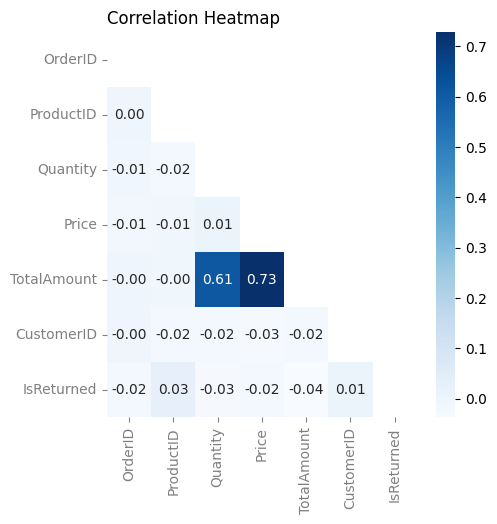

In [13]:
plt.figure(figsize=(5, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap', loc='left') # Remove. Add as subtitle to the presentation instead
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')
plt.show()

In [14]:
customer_sales = df[df['IsReturned'] != 1].groupby('CustomerID')['TotalAmount'].agg([('TotalAmount', 'sum'), ('UniqueOrders', 'count')])

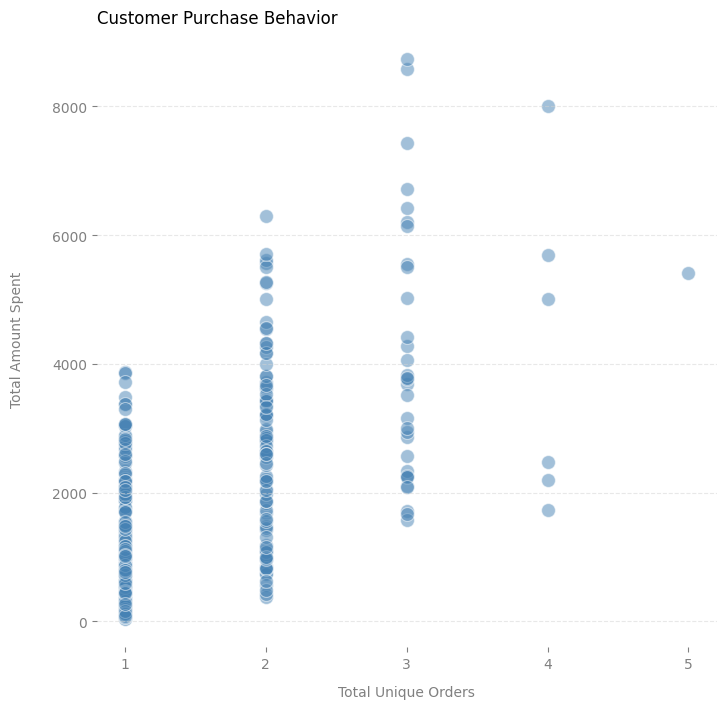

In [15]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='UniqueOrders', y='TotalAmount', data=customer_sales, color='steelblue', alpha=0.5, s=100)
plt.title('Customer Purchase Behavior', loc='left') # Remove. Add as subtitle to the presentation instead
plt.xlabel('Total Unique Orders', color='grey', fontsize=10, labelpad=10)
plt.ylabel('Total Amount Spent', color='grey', fontsize=10, labelpad=20)

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')
plt.xticks(range(1, max(customer_sales['UniqueOrders']) + 1))
plt.show()

In [16]:
customer_sales_sorted = customer_sales.sort_values(by='TotalAmount', ascending=False)

total_customers = len(customer_sales_sorted)
top_10_percent_threshold = int(total_customers * 0.1)
top_10_percent_customers = customer_sales_sorted.head(top_10_percent_threshold)
print(f'Recommendation: Consider a VIP program for those {len(top_10_percent_customers)} customers:\n')
print("Top 10% of Customers Based on Spending:")
top_10_percent_customers.style.background_gradient()


Recommendation: Consider a VIP program for those 30 customers:

Top 10% of Customers Based on Spending:


,TotalAmount,UniqueOrders
CustomerID,,
383,8728.860000,3
205,8579.150000,3
466,8008.910000,4
141,7429.050000,3
9,6722.230000,3
160,6425.240000,3
157,6304.270000,2
40,6204.820000,3
307,6136.780000,3


**Observations and insights**

It is interesting to explplore this Top 10% category futher. Also we need to check if those customers are part of SalesEase's loyalty programs already and if those programs influence their spending.

In [17]:
top_customers_data = df[(df['IsReturned'] != 1) & (df['CustomerID'].isin(top_10_percent_customers.index))]
top_purchase_frequency = top_customers_data.groupby('CustomerID')['OrderDate'].count()
top_types_of_categories = top_customers_data.groupby('CustomerID')['Category'].nunique()
top_average_order_value = top_customers_data.groupby('CustomerID')['TotalAmount'].mean()
top_total_spent = top_customers_data.groupby('CustomerID')['TotalAmount'].sum()

top_purchase_behavior = pd.DataFrame({
    'PurchaseFrequency': top_purchase_frequency,
    'Categories': top_types_of_categories,
    'AverageOrder': top_average_order_value,
    'TotalSpent': top_total_spent
})
print('Purchase Behavior of Top 10% Customers:')
top_purchase_behavior.style.background_gradient()

Purchase Behavior of Top 10% Customers:


,PurchaseFrequency,Categories,AverageOrder,TotalSpent
CustomerID,,,,
2,2,2,2268.415000,4536.830000
9,3,2,2240.743333,6722.230000
40,3,2,2068.273333,6204.820000
76,2,2,2165.240000,4330.480000
88,2,2,2631.465000,5262.930000
97,3,2,1675.810000,5027.430000
110,3,2,1850.540000,5551.620000
127,2,1,2781.740000,5563.480000
141,3,3,2476.350000,7429.050000


In [18]:
# Customer retention rate
total_customers = len(customer_sales)
repeat_customers = len(customer_sales[customer_sales['UniqueOrders'] > 1])
retention_rate = (repeat_customers / total_customers) * 100

# Average order frequency
average_order_frequency = customer_sales['UniqueOrders'].mean()

# Average Customer Lifetime Value (CLV)
average_clv = customer_sales['TotalAmount'].mean()

print(f'Customer Retention Rate: {retention_rate:.2f}%')
print(f'Average Order Frequency: {average_order_frequency:.2f}')
print(f'Average Customer Lifetime Value (CLV): {average_clv:.2f}')

Customer Retention Rate: 43.28%
Average Order Frequency: 1.59
Average Customer Lifetime Value (CLV): 2088.66


## 4. Product Analysis

<Figure size 1200x1200 with 0 Axes>

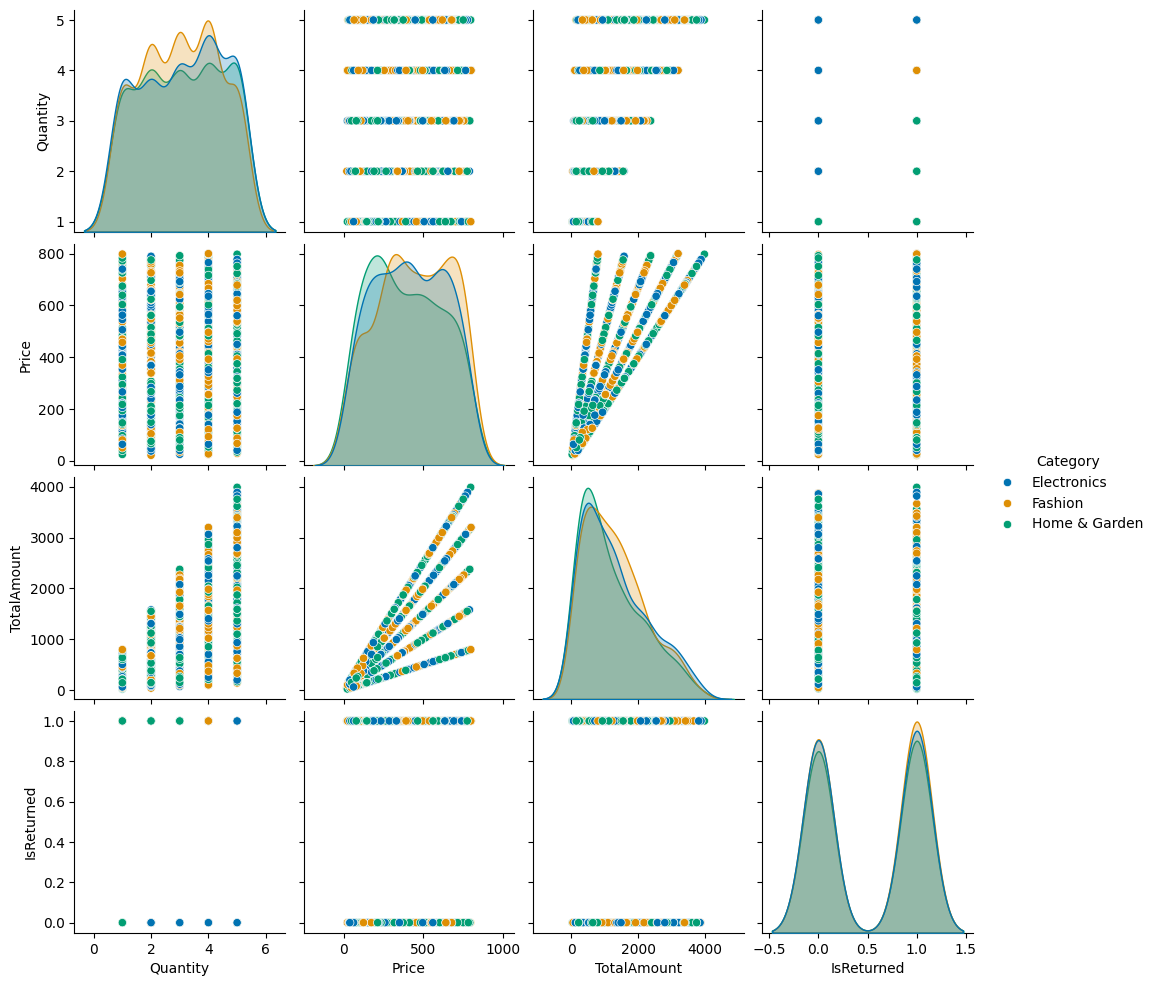

In [19]:
include_columns = [col for col in df.columns if col not in ['OrderID', 'ProductID', 'CustomerID']]

plt.figure(figsize=(12, 12))
pairplot = sns.pairplot(df[include_columns], hue='Category', palette='colorblind')
plt.show()

In [20]:

product_sales_by_category = df[df['IsReturned'] != 1].groupby(['Category', 'ProductName'])['Quantity'].sum().reset_index()

top_5_products_by_category = product_sales_by_category.sort_values(['Category', 'Quantity'], ascending=[True, False])
top_5_products_by_category = top_5_products_by_category.groupby('Category').head(5).reset_index(drop=True)
top_5_products_by_category.style.background_gradient()
     

,Category,ProductName,Quantity
0,Electronics,Product_295,15
1,Electronics,Product_444,13
2,Electronics,Product_374,10
3,Electronics,Product_477,10
4,Electronics,Product_143,9
5,Fashion,Product_174,11
6,Fashion,Product_228,11
7,Fashion,Product_409,10
8,Fashion,Product_220,9
9,Fashion,Product_328,9


## 5. Payment and Returns Analysis

In [21]:
returned_orders = df[df['IsReturned'] == 1]
# Calculate the return rate for each category
total_orders_by_category = df.groupby('Category')['OrderID'].count().reset_index()
returned_orders_by_category = returned_orders.groupby('Category')['OrderID'].count().reset_index()
return_rate_by_category = pd.merge(total_orders_by_category, returned_orders_by_category, on='Category', how='left')
return_rate_by_category.columns = ['Category', 'TotalOrders', 'ReturnedOrders']
return_rate_by_category['ReturnRate'] = (return_rate_by_category['ReturnedOrders'] / return_rate_by_category['TotalOrders']) * 100

# Calculate the return rate for each payment method
total_orders_by_payment = df.groupby('PaymentMethod')['OrderID'].count().reset_index()
returned_orders_by_payment = returned_orders.groupby('PaymentMethod')['OrderID'].count().reset_index()
return_rate_by_payment = pd.merge(total_orders_by_payment, returned_orders_by_payment, on='PaymentMethod', how='left')
return_rate_by_payment.columns = ['PaymentMethod', 'TotalOrders', 'ReturnedOrders']
return_rate_by_payment['ReturnRate'] = (return_rate_by_payment['ReturnedOrders'] / return_rate_by_payment['TotalOrders']) * 100

# Display the return rates by category and payment method
print(return_rate_by_category)
print()
print(return_rate_by_payment)

        Category  TotalOrders  ReturnedOrders  ReturnRate
0    Electronics          336             172   51.190476
1        Fashion          343             179   52.186589
2  Home & Garden          321             165   51.401869

  PaymentMethod  TotalOrders  ReturnedOrders  ReturnRate
0          Cash          311             176   56.591640
1   Credit Card          343             170   49.562682
2        PayPal          346             170   49.132948


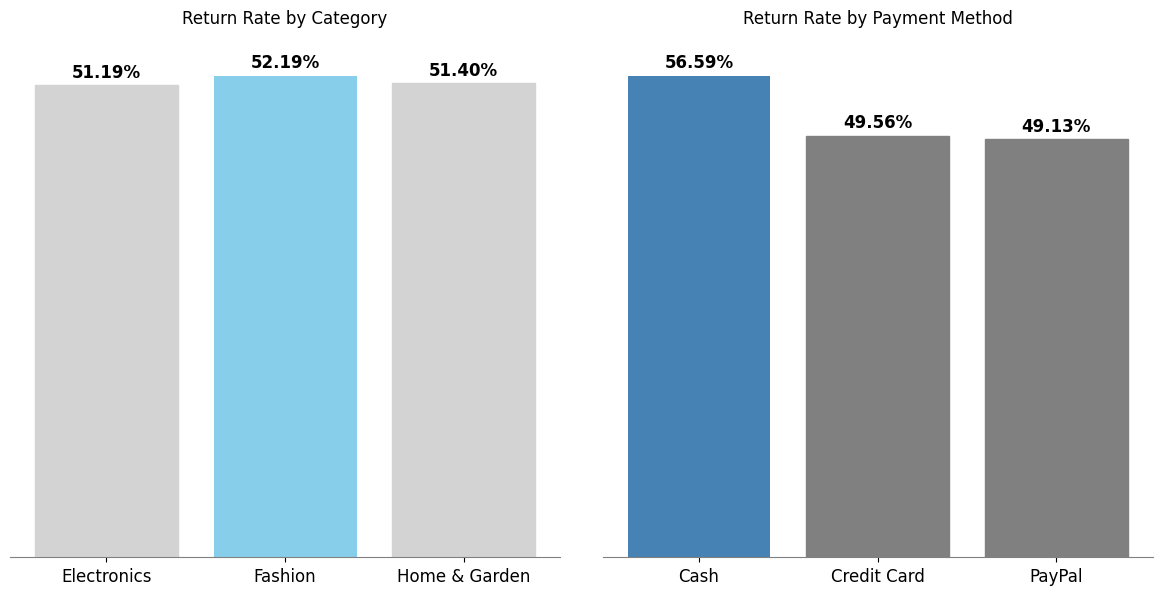

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Rates by category
bars1 = axes[0].bar(return_rate_by_category['Category'], return_rate_by_category['ReturnRate'], color='skyblue')
axes[0].set_title('Return Rate by Category', y=1.04) # Remove. Add as subtitle to the presentation instead
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize = 12 ,fontweight='bold')
for i, bar in enumerate(bars1):
    if i == np.argmax(return_rate_by_category['ReturnRate']):
        continue
    bar.set_color('lightgrey')

# Rates by payment method
bars2 = axes[1].bar(return_rate_by_payment['PaymentMethod'], return_rate_by_payment['ReturnRate'], color='steelblue')
axes[1].set_title('Return Rate by Payment Method', y=1.04) # Remove. Add as subtitle to the presentation instead
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize = 12 ,fontweight='bold')
for i, bar in enumerate(bars2):
    if i == np.argmax(return_rate_by_payment['ReturnRate']):
        continue
    bar.set_color('grey')

plt.tight_layout()
sns.despine()
for ax in axes:
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='x', colors='black', labelsize=12)
plt.show()

In [23]:
returned_products_count = returned_orders.groupby('ProductName')['IsReturned'].count().reset_index()
most_returned_products = returned_products_count.sort_values('IsReturned', ascending=False).head(10)
most_returned_products

,ProductName,IsReturned
279,Product_489,6
142,Product_297,6
57,Product_183,5
208,Product_392,5
206,Product_390,5
109,Product_248,5
204,Product_388,4
64,Product_193,4
73,Product_205,4
163,Product_326,4


In [24]:
count_by_category = returned_orders.groupby(['ProductID', 'Category'])['IsReturned'].count().reset_index()
most_returned_products = count_by_category.sort_values('IsReturned', ascending=False).head(10)
most_returned_products

,ProductID,Category,IsReturned
406,489,Electronics,4
205,297,Electronics,4
231,326,Electronics,3
359,445,Home & Garden,3
112,205,Electronics,3
383,468,Electronics,3
295,392,Fashion,3
148,235,Fashion,3
36,138,Home & Garden,3
290,390,Fashion,3


In [25]:
product_489 = df[df['ProductID'] == 489]
product_489

,OrderID,ProductID,Category,ProductName,Quantity,Price,TotalAmount,OrderDate,CustomerID,PaymentMethod,SalesChannel,IsReturned,YearMonth,Month,Weekday
58,59,489,Fashion,Product_489,1,742.49,742.49,2022-07-05 13:16:29,186,Cash,In-Store,0,2022-07,Jul,Tuesday
677,678,489,Home & Garden,Product_489,5,526.27,2631.35,2022-04-01 19:59:00,111,Cash,Mobile App,1,2022-04,Apr,Friday
830,831,489,Electronics,Product_489,5,179.80,899.00,2022-02-24 07:25:36,426,Cash,Mobile App,1,2022-02,Feb,Thursday
850,851,489,Electronics,Product_489,1,205.61,205.61,2022-06-30 09:25:42,188,Cash,In-Store,1,2022-06,Jun,Thursday
876,877,489,Electronics,Product_489,3,412.88,1238.64,2022-07-29 21:59:19,217,Cash,Website,1,2022-07,Jul,Friday
892,893,489,Home & Garden,Product_489,4,627.30,2509.20,2022-06-12 06:37:24,70,Credit Card,Mobile App,1,2022-06,Jun,Sunday
971,972,489,Electronics,Product_489,4,175.97,703.88,2022-04-21 18:17:45,6,PayPal,Website,1,2022-04,Apr,Thursday


In [26]:
product_297 = df[df['ProductID'] == 297]
product_297

,OrderID,ProductID,Category,ProductName,Quantity,Price,TotalAmount,OrderDate,CustomerID,PaymentMethod,SalesChannel,IsReturned,YearMonth,Month,Weekday
31,32,297,Home & Garden,Product_297,1,440.84,440.84,2022-04-05 17:59:01,412,PayPal,In-Store,0,2022-04,Apr,Tuesday
107,108,297,Electronics,Product_297,5,220.44,1102.20,2022-05-07 15:54:37,435,Cash,Website,1,2022-05,May,Saturday
234,235,297,Fashion,Product_297,5,673.82,3369.10,2022-04-08 12:55:47,126,PayPal,Mobile App,0,2022-04,Apr,Friday
284,285,297,Electronics,Product_297,4,406.08,1624.32,2022-06-24 14:28:56,103,Cash,Website,1,2022-06,Jun,Friday
515,516,297,Fashion,Product_297,5,733.23,3666.15,2022-02-06 14:48:59,21,PayPal,Website,1,2022-02,Feb,Sunday
634,635,297,Home & Garden,Product_297,2,180.97,361.94,2022-06-12 04:58:37,132,Credit Card,Website,0,2022-06,Jun,Sunday
655,656,297,Electronics,Product_297,2,285.38,570.76,2022-08-12 23:18:15,197,Credit Card,In-Store,1,2022-08,Aug,Friday
699,700,297,Fashion,Product_297,1,252.12,252.12,2022-04-01 10:44:26,302,PayPal,Mobile App,1,2022-04,Apr,Friday
703,704,297,Electronics,Product_297,2,275.38,550.76,2022-08-02 14:39:34,318,PayPal,Mobile App,1,2022-08,Aug,Tuesday
965,966,297,Electronics,Product_297,5,318.63,1593.15,2022-06-29 01:31:57,482,Credit Card,Website,0,2022-06,Jun,Wednesday


**Observations and insights**

Analysing top returned products it has become clear that the same product listed and purcased across different categories, including Home & Garden, Electronics, and Fashion. Also, just for the ProductID 297 price ranges from 180.97USD to 733.23USD per unit within just eight month. Also, there are no sales observed within 28 and even 90 days before the return. **That can indicate errors in data collection.**

It would be wise to explore potential strategies for return rates reduction, such as improving product descriptions, enhancing product quality, or providing better customer support.
